In [1]:
#%matplotlib notebook

import re

import gemmi
import numpy as np
import reciprocalspaceship as rs
from glob import glob
from natsort import natsorted

from scipy.stats import differential_entropy
from scipy.stats import kurtosis

from matplotlib import pyplot as plt

In [43]:
def negentropy(X):
    """
    Return negentropy (float) of X (numpy array)
    """
    
    # negetropy is the difference between the entropy of samples x
    # and a Gaussian with same variance
    # http://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/
    
    std = np.std(X)
    #neg_e = np.log(std*np.sqrt(2*np.pi*np.exp(1))) - differential_entropy(X)
    neg_e = 0.5 * np.log(2.0 * np.pi * std ** 2) + 0.5 - differential_entropy(X)
    #assert neg_e >= 0.0
    
    return neg_e

def mtz_to_stats(mtz_path):
    mtz = gemmi.read_mtz_file(mtz_path)
    grid = mtz.transform_f_phi_to_map('FOFOWT', 'PHIFOFOWT', sample_rate=3)
    x = np.array(grid).flatten()
    return np.array([-0.1, negentropy(x), kurtosis(x)])


In [44]:
basedir = '/Users/tjlane/Desktop/k-weight-deds/'

no_weight_mtz = basedir + '10ns_noW_mFoFo.mtz'
q_weight_mtz  = basedir + '10ns_qW_mqFoFo.mtz'
k_weight_mtzs = glob(basedir + '10ns_k*W_mkFoFo.mtz')

In [63]:
kwt_stats = np.zeros((len(k_weight_mtzs) + 2, 3))

mtz = gemmi.read_mtz_file(no_weight_mtz)
grid = mtz.transform_f_phi_to_map('FOFOWT', 'PHIFOFOWT', sample_rate=3)
x = np.array(grid).flatten()
kwt_stats[0,:] = np.array([-0.1, negentropy(x), kurtosis(x)])

mtz = gemmi.read_mtz_file(q_weight_mtz)
grid = mtz.transform_f_phi_to_map('QFOFOWT', 'PHIQFOFOWT', sample_rate=3)
x = np.array(grid).flatten()
kwt_stats[1,:] = np.array([-0.05, negentropy(x), kurtosis(x)])

for i,kw_mtz in enumerate(k_weight_mtzs):

    mtz = gemmi.read_mtz_file(kw_mtz)
    grid = mtz.transform_f_phi_to_map('KFOFOWT', 'PHIKFOFOWT', sample_rate=3)
    x = np.array(grid).flatten()
    g = re.search(r'10ns_k(\d+)p(\d+)W_mkFoFo.mtz', kw_mtz)

    k_wt = float(g.group(1) + '.' +g.group(2))
    kwt_stats[i+2,:] = np.array([ k_wt, negentropy(x), kurtosis(x) ])

kwt_stats = kwt_stats[np.argsort(kwt_stats[:,0]),:]

<Figure size 640x480 with 0 Axes>

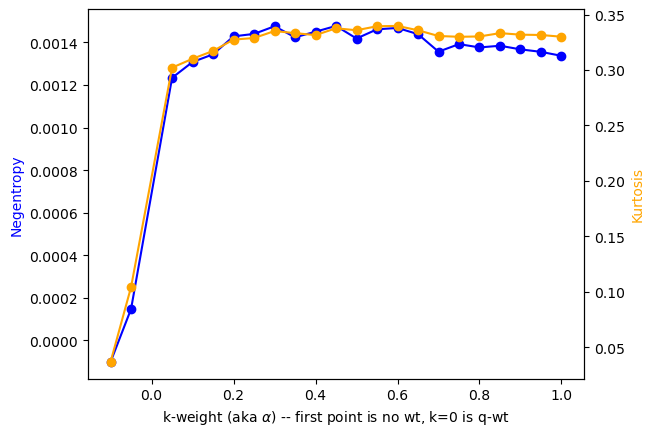

<Figure size 640x480 with 0 Axes>

In [64]:
plt.figure()

ax = plt.subplot(111)
p1 = ax.plot(kwt_stats[:,0], kwt_stats[:,1], color='blue')
ax.plot(kwt_stats[:,0], kwt_stats[:,1], 'o', color='blue')

plt.xlabel(r'k-weight (aka $\alpha$) -- first point is no wt, k=0 is q-wt')
ax.set_ylabel('Negentropy', color='blue')

ax2 = plt.twinx()
p2 = ax2.plot(kwt_stats[:,0], kwt_stats[:,2], color='orange')
ax2.plot(kwt_stats[:,0], kwt_stats[:,2], 'o', color='orange')
ax2.set_ylabel('Kurtosis', color='orange')

plt.figure()

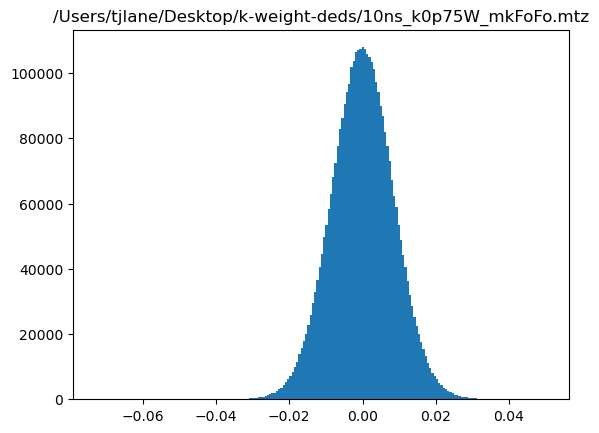

In [59]:
fn = k_weight_mtzs[-1]

plt.figure()
plt.hist(np.array(grid).flatten(), 200)
plt.title(fn)
plt.show()